In [1]:
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt

exec(open("functions.py").read())

h_acov

In [36]:
# generic numerical function helpers
def num_primitive_fct(num_function, baseline_idx, x_resolution, axis =-1):
  sum_left = jnp.cumsum(num_function, axis = axis) / x_resolution
  sum_right = jnp.cumsum(-num_function[..., ::-1], axis = axis)[..., ::-1] / x_resolution
  mean_sum = (sum_left + sum_right) / 2
  return(mean_sum - mean_sum[..., baseline_idx:(baseline_idx + 1)])

def num_integral_fct(num_function, x_resolution, axis =-1):
  sum_left = jnp.sum(num_function[..., :-1], axis = axis) / x_resolution
  sum_right = jnp.sum(num_function[..., 1:], axis = axis) / x_resolution
  return((sum_left + sum_right) / 2)

def mirror(traj, transformation = lambda x:x):
  return(jnp.concatenate([transformation(traj[..., 1:][..., ::-1]), traj], axis = -1))



def stable_h_var_fct(unscaled_std, g_tanh = "out", 
                     init_search_window = jnp.asarray([1,100]), search_resolution = 30, 
                     search_precision = 0.0001, 
                     num_fct_domain = jnp.asarray([-5, 5]), num_fct_resolution = 100):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  zero_iv_idx = jnp.searchsorted(iv_s, 0)
  sta_gau_s = 1/jnp.sqrt(2*jnp.pi) * jnp.exp(- iv_s ** 2 /2)
  tanh_pri_s = num_primitive_fct(jnp.tanh(iv_s), zero_iv_idx, num_fct_resolution)
  def sta_gau_fct(iv):
    return(jnp.interp(iv, iv_s, sta_gau_s, left = 0, right = 0))
  def tanh_pri_fct(iv):
    return(jnp.interp(iv, iv_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))
  # while
  search_window = init_search_window
  h_var = 0
  while (search_window[1] - search_window[0]) > search_precision:
    h_var_s = (search_window[0] 
               + jnp.arange(search_resolution) / search_resolution * (search_window[1] - search_window[0]))
    if g_tanh == "out":
      init_potential_s = (
        - (h_var_s ** 2 / 2)
        + num_integral_fct(tanh_pri_fct(iv_s * jnp.sqrt(jnp.expand_dims(h_var_s, 1))) **2
                           * sta_gau_fct(iv_s), 
                           num_fct_resolution) * unscaled_std ** 2 
         - num_integral_fct(tanh_pri_fct(iv_s * jnp.sqrt(jnp.expand_dims(h_var_s, 1)))
                            * sta_gau_fct(iv_s), 
                            num_fct_resolution) **2 * unscaled_std ** 2)
    elif g_tanh == "in":
      init_potential_s = (
        - (h_var_s ** 2 / 2)
        + num_integral_fct(tanh_pri_fct(unscaled_std * iv_s * jnp.sqrt(jnp.expand_dims(h_var_s, 1))) **2
                           * sta_gau_fct(iv_s), 
                           num_fct_resolution) / unscaled_std ** 2 
        - num_integral_fct(tanh_pri_fct(unscaled_std * iv_s * jnp.sqrt(jnp.expand_dims(h_var_s, 1)))
                           * sta_gau_fct(iv_s), 
                           num_fct_resolution) **2 / unscaled_std ** 2)
    decreasing_piece = init_potential_s[jnp.searchsorted(init_potential_s, jnp.max(init_potential_s)):]
    h_var_idx = jnp.searchsorted(-init_potential_s, 0)
    h_var = h_var_s[h_var_idx]
    search_window = h_var_s[jnp.asarray([h_var_idx - 2, h_var_idx + 1])]
  return([h_var, h_var_s, init_potential_s])

def h_acov_fct(h_var, unscaled_std, g_tanh = "out", 
               h_acov_resolution = 100, sim_len = 100, sim_resolution = 30, connection_pos = 5,
               num_fct_domain = jnp.asarray([-5, 5]), num_fct_resolution = 100):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  zero_iv_idx = jnp.searchsorted(iv_s, 0)
  sta_gau_s = 1/jnp.sqrt(2*jnp.pi) * jnp.exp(- iv_s ** 2 /2)
  tanh_pri_s = num_primitive_fct(jnp.tanh(iv_s), zero_iv_idx, num_fct_resolution)
  def sta_gau_fct(iv):
    return(jnp.interp(iv, iv_s, sta_gau_s, left = 0, right = 0))
  def tanh_pri_fct(iv):
    return(jnp.interp(iv, iv_s, tanh_pri_s, left = "extrapolate", right = "extrapolate"))
  # h_acov_s grid
  h_acov_step_n = jnp.round(jnp.maximum(h_acov_resolution, h_acov_resolution * h_var)).astype(int)
  h_acov_idx_s = jnp.arange(h_acov_step_n + 1)
  h_acov_s = h_acov_idx_s / h_acov_step_n * h_var
  # potential
  potential_1 = -(h_acov_s ** 2 / 2)
  if g_tanh == "out":
    potential_2 = num_integral_fct(
      num_integral_fct(
        tanh_pri_fct(jnp.expand_dims(iv_s, (0, 1)) * jnp.sqrt(h_var - jnp.expand_dims(h_acov_s, (1, 2)))
                     + jnp.expand_dims(iv_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
        * jnp.expand_dims(sta_gau_fct(iv_s), (0, 1)), num_fct_resolution) ** 2
      * jnp.expand_dims(sta_gau_fct(iv_s), 0), num_fct_resolution) * unscaled_std ** 2
    potential_3 = -num_integral_fct(tanh_pri_fct(iv_s * jnp.sqrt(h_var))
                               * sta_gau_fct(iv_s), num_fct_resolution) ** 2 * unscaled_std ** 2
  elif g_tanh == "in":
    potential_2 = num_integral_fct(
      num_integral_fct(
        tanh_pri_fct(unscaled_std * jnp.expand_dims(iv_s, (0, 1)) * jnp.sqrt(h_var - jnp.expand_dims(h_acov_s, (1, 2)))
                     + unscaled_std * jnp.expand_dims(iv_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
        * jnp.expand_dims(sta_gau_fct(iv_s), (0, 1)), num_fct_resolution) ** 2
      * jnp.expand_dims(sta_gau_fct(iv_s), 0), num_fct_resolution) / unscaled_std ** 2
    potential_3 = -num_integral_fct(tanh_pri_fct(unscaled_std * iv_s * jnp.sqrt(h_var))
                                      * sta_gau_fct(iv_s), num_fct_resolution) ** 2 / unscaled_std ** 2
  potential = potential_1 + potential_2 + potential_3
  potential = potential - potential[0]
  # force
  # # integration vs gradient has tiny differences
  # force_1 = h_acov_s
  # if g_tanh == "out":
  #   force_2 = -num_integral_fct(
  #     num_integral_fct(
  #       jnp.tanh(jnp.expand_dims(iv_s, (0, 1)) * jnp.sqrt(h_var - jnp.expand_dims(h_acov_s, (1, 2))) 
  #                + jnp.expand_dims(iv_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
  #       * jnp.expand_dims(sta_gau_fct(iv_s), (0, 1)), num_fct_resolution) ** 2 
  #     * jnp.expand_dims(sta_gau_fct(iv_s), 0), num_fct_resolution) * unscaled_std ** 2
  # elif g_tanh == "in":
  #   force_2 = -num_integral_fct(
  #     num_integral_fct(
  #       jnp.tanh(unscaled_std * jnp.expand_dims(iv_s, (0, 1)) * jnp.sqrt(h_var - jnp.expand_dims(h_acov_s, (1, 2)))
  #                + unscaled_std * jnp.expand_dims(iv_s, (0, 2)) * jnp.sqrt(jnp.expand_dims(h_acov_s, (1, 2))))
  #       * jnp.expand_dims(sta_gau_fct(iv_s), (0, 1)), num_fct_resolution) ** 2
  #     * jnp.expand_dims(sta_gau_fct(iv_s), 0), num_fct_resolution)
  # force = force_1 + force_2
  force = -jnp.gradient(potential) * h_acov_step_n / h_var
  # evolve h_acov
  sim_interval_2d = jnp.asarray([0, connection_pos])
  sim_interval_1d = jnp.asarray([connection_pos, sim_len])
  def h_acov_2d_velocity_fct(pos_vel):
    return(jnp.asarray([pos_vel[1], 
                        jnp.interp(pos_vel[0], h_acov_s, force, left = 0, right = "extrapolate")]))
  def h_acov_1d_velocity_fct(h_acov):
    return(jnp.interp(h_acov, h_acov_s, -jnp.sqrt(jnp.maximum(-2 * potential, 0)), 
                      left = 0, right = "extrapolate"))
  h_acov_2d = traj_initializer(jnp.asarray([h_var, 0]), sim_interval_2d, sim_resolution)
  h_acov_2d = rk4_ode_solver(h_acov_2d_velocity_fct, lambda time: 0, h_acov_2d, sim_interval_2d[0], sim_resolution)
  h_acov_1d = traj_initializer(jnp.asarray(h_acov_2d[0,-1]), sim_interval_1d, sim_resolution)
  h_acov_1d = rk4_ode_solver(h_acov_1d_velocity_fct, lambda time: 0, h_acov_1d, sim_interval_1d[0], sim_resolution)
  h_acov = jnp.concatenate([jnp.asarray([h_var]), h_acov_2d[0], h_acov_1d])
  # corresponding times
  acov_lag_s = jnp.arange(sim_len * sim_resolution + 1) / sim_resolution
  return([jnp.asarray([acov_lag_s, h_acov]), potential, force])

# def r_acov_fct(timed_h_acov, unscaled_std, g_tanh = "out"):
#   # mirror to remove ringings
#   mirrored_lag_s = mirror(timed_h_acov[0], lambda x:-x)
#   mirrored_h_acov = mirror(timed_h_acov[1])
#   # ft variables
#   ft_n = mirrored_lag_s.shape[0]
#   rft_n = jnp.ceil((ft_n + 1) / 2).astype(int)
#   interval_len = mirrored_lag_s[-1] - mirrored_lag_s[0]
#   rft_omega_s = 2 * jnp.pi * jnp.arange(rft_n)  / interval_len
#   # ft
#   r_acov_rft = jnp.fft.rfft(mirrored_h_acov) * (1 + rft_omega_s ** 2)
#   if g_tanh == "out":
#     r_acov_rft = r_acov_rft / unscaled_std ** 2
#   r_acov = jnp.asarray([mirrored_lag_s, jnp.fft.irfft(r_acov_rft, n = ft_n)])
#   return(r_acov)

def all_cov_s_fct(timed_h_acov, unscaled_std, g_tanh = "out",
              num_fct_domain = jnp.asarray([-5, 5]), num_fct_resolution = 100):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution # interval > 1
  sta_gau_s = 1 / jnp.sqrt(2 * jnp.pi) * jnp.exp(- iv_s ** 2 / 2)
  tanh_der_s = jnp.gradient(jnp.tanh(iv_s)) * num_fct_resolution
  def sta_gau_fct(iv):
    return(jnp.interp(iv, iv_s, sta_gau_s, left = 0, right = 0))
  def tanh_der_fct(x):
    return(jnp.interp(iv, iv_s, tanh_der_s, left = "extrapolate", right = "extrapolate"))
  # mirror to remove ringings
  mirrored_lag_s = mirror(timed_h_acov[0], lambda x:-x)
  mirrored_h_acov = mirror(timed_h_acov[1])
  # ft variables
  ft_n = mirrored_lag_s.shape[0]
  rft_n = jnp.ceil((ft_n + 1) / 2).astype(int)
  interval_len = mirrored_lag_s[-1] - mirrored_lag_s[0]
  rft_omega_s = 2 * jnp.pi * jnp.arange(rft_n)  / interval_len
  ft_omega_s = jnp.concatenate([rft_omega_s, -(rft_omega_s[..., 1:][..., ::-1])])
  mean_gain = num_integral_fct(tanh_der_fct(jnp.sqrt(init_h_acov) * iv_s) * sta_gau_fct(iv_s), num_fct_resolution)
  temp_nn_s = unscaled_std ** 2 * mean_gain ** 2
  temp_xx_s = ((1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 1)))
               * (1 + jax.lax.complex(0., jnp.expand_dims(ft_omega_s, 0))))
  # ft # should not use rft since eventually 2d
  h_acov_ft = jnp.fft.fft(mirrored_h_acov)
  r_acov_ft = h_acov_traj_ft * (1+ ft_omega_s**2)
  if g_tanh == "out":
    r_acov_ft = r_acov_ft / unscaled_std ** 2
  h_ccov_sq_ft = (((2 * jnp.abs(temp_xx_s) ** 2 - temp_nn_s ** 2)
                   / jnp.abs(temp_xx_s - unscaled_std ** 2 * mean_gain ** 2) ** 2 
                   - 1)
                  * jnp.expand_dims(h_acov_traj_ft, 1) * jnp.expand_dims(h_acov_traj_ft, 0))
  r_ccov_sq_ft = ((jnp.abs(temp_xx_s / (temp_xx_s - temp_nn_s)) ** 2 - 1)
                  * jnp.expand_dims(r_acov_traj_ft, 1) * jnp.expand_dims(r_acov_traj_ft, 0))
  r_acov = jnp.fft.irfft(h_ccov_sq_ft[:rft_n], ft_n)
  h_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(h_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  r_ccov_sq = jnp.fft.irfft(jnp.fft.ifft(r_ccov_sq_ft[:rft_n], ft_n, 1), ft_n, 0)
  # r_acov = jnp.real(jnp.fft.ifft(h_ccov_sq_ft, ft_n))
  # h_ccov_sq = jnp.real(jnp.fft.ifft2(h_ccov_sq_ft, (ft_n,ft_n)))
  # r_ccov_sq = jnp.real(jnp.fft.ifft2(r_ccov_sq_ft, (ft_n,ft_n)))  
  return([jnp.asarray([mirrored_lag_s, mirrored_h_acov, r_acov]),
          jnp.asarray([h_ccov_sq, r_ccov_sq])])

def prediction_s(all_cov_s, relative_lag_s, window_len_s, part_n_s
                 num_fct_domain = jnp.asarray([-5, 5]), num_fct_resolution = 100):
  # numeric parameters & extrapolated numeric functions
  iv_s = jnp.arange(*jnp.round(num_fct_domain * num_fct_resolution).astype(int)) / num_fct_resolution
  long_num_fct_domain_len = jnp.ceil(window_len_s[-1]* 2.5).astype(int)
  long_iv_s = (jnp.arange(long_num_fct_domain_len * num_fct_resolution) / num_fct_resolution
               - long_num_fct_domain_len / 2)
  sta_gau_s = 1 / jnp.sqrt(2 * jnp.pi) * jnp.exp(- iv_s ** 2 / 2)
  def sta_gau_fct(iv):
    return(jnp.interp(iv, iv_s, sta_gau_s, left = 0, right = 0))
  # unpack and turn into functions
  [acov_s, ccov_sq_s] = all_cov_s
  [lag_s, h_acov, r_acov] = acov_s
  [h_ccov_sq, r_ccov_sq] = ccov_sq_s
  def h_acov_fct(x):
    return(jnp.interp(x, lag_s, h_acov, left = 0, right = 0))
  def h_ccov_sq_main_fct(x):
    return(jnp.interp(x, lag_s, jnp.einsum("ii->i",h_ccov_sq), left = 0, right = 0))
  def h_ccov_sq_off_fct(x):
    return(jnp.interp(x, lag_s, jnp.einsum("ii->i",h_ccov_sq[:,::-1]), left = 0, right = 0))
  def r_acov_fct(x):
    return(jnp.interp(x, lag_s, r_acov, left = 0, right = 0))
  def r_ccov_sq_main_fct(x):
    return(jnp.interp(x, lag_s, jnp.einsum("ii->i",r_ccov_sq), left = 0, right = 0))
  def r_ccov_sq_off_fct(x):
    return(jnp.interp(x, lag_s, jnp.einsum("ii->i",r_ccov_sq[:,::-1]), left = 0, right = 0))
  # local_cvar_sq
  def local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                          relative_lag_s, window_len_s, part_n_s):
    std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
    relative_lag_s = jnp.expand_dims(relative_lag_s, (1, 2))
    part_n_s = jnp.expand_dims(part_n_s, (1,2))
    filter_s = sta_gau_fct(long_iv_s / std_s - relative_lag_s) / std_s
    iiii = acov_fct(0) ** 2 + num_integral_fct(2* acov_fct(long_iv_s) **2
                                               * filter_s, num_fct_resolution)
    iijj = (acov_fct(0) ** 2
            + 2 / part_n_s * num_integral_fct(ccov_sq_main_fct(long_iv_s)
                                              * filter_s, num_fct_resolution))
    ijij = (ccov_sq_off_fct(0) / part_n_s
            + num_integral_fct(acov_fct(long_iv_s) **2
                               * filter_s, num_fct_resolution)
            +  1 / part_n_s * num_integral_fct(ccov_sq_off_fct(long_iv_s)
                                               * filter_s, num_fct_resolution))
    return([iiii, iijj, ijij])
  # predictions for h or r
  def pr_os_s(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct, relative_lag_s, window_len_s, part_n_s):
    [local_cvar_sq_iiii, local_cvar_sq_iijj, local_cvar_sq_ijij
     ] = local_cvar_sq_s_fct(acov_fct, ccov_sq_main_fct, ccov_sq_off_fct,
                             jnp.concatenate([jnp.asarray([0]), relative_lag_s]),
                             window_len_s, part_n_s)
    relative_lag_s = jnp.expand_dims(relative_lag_s, 1)
    part_n_s = jnp.expand_dims(part_n_s, (1,2))
    return([(local_cvar_sq_iiii[:, 0] + (part_n_s - 1) * local_cvar_sq_iijj[:, 0])
            / (part_n_s * local_cvar_sq_iiii[:, 0] + (1 - 1 / part_n_s) * local_cvar_sq_ijij[:, 0]),
            (local_cvar_sq_iiii[:, 1:] + (part_n_s - 1) * local_cvar_sq_ijij[:, 1:])
            / (local_cvar_sq_iiii[:, 0:1] + (part_n_s - 1) * local_cvar_sq_ijij[:, 0:1]),
            jnp.sqrt((acov_fct(0) ** 2 + (part_n_s - 1) / part_n_s * ccov_sq_main_fct(0))
                     / (local_cvar_sq_iiii[:, 0] + (part_n_s - 1) * local_cvar_sq_ijij[:, 0]))])
  h_prediction_s = pr_os_s(h_acov_fct, h_ccov_sq_main_fct, h_ccov_sq_off_fct,
                           relative_lag_s, window_len_s, part_n_s)
  r_prediction_s = pr_os_s(r_acov_fct, r_ccov_sq_main_fct, r_ccov_sq_off_fct,
                           relative_lag_s, window_len_s, part_n_s)
  return([h_prediction_s, r_prediction_s])

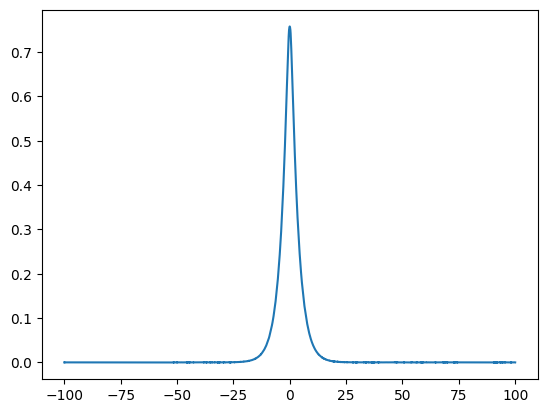

In [38]:
all_cov_s = all_cov_s_fct(h_acov_fct(stable_h_var_fct(4)[0], 4)[0], 4)

part_n_s = jnp.asarray([500, 1000, 2000])
window_len_s = jnp.asarray([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])

In [10]:
#verify length is enough for filters
std_s = jnp.expand_dims(window_len_s / jnp.sqrt(2),1)
num_integral_fct(sta_gau_fct(pr_lag_s/std_s)/std_s, x_resolution)

Array([0.99999934, 0.99999934, 0.99999946, 0.9999994 , 0.99999946,
       0.99999946, 0.99999946, 0.9999994 , 0.999593  ], dtype=float32)

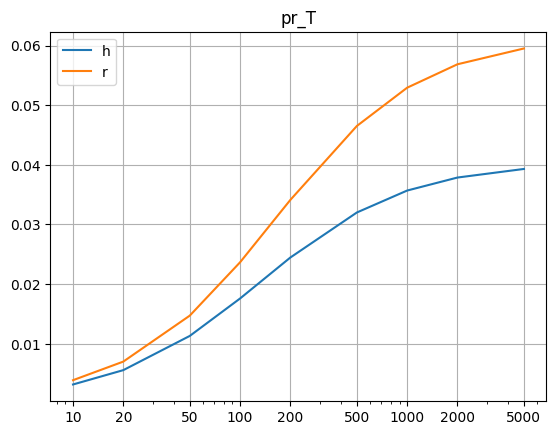

In [11]:
# turn to functions # avoid running for longer lens just to allow larger windows 


# cvar_sqs


plt.title("pr_T")
plt.plot(window_len_s, h_pr_s, label = "h")
plt.plot(window_len_s, r_pr_s, label = "r")
plt.xscale("log")
plt.xticks(window_len_s, labels = window_len_s)
plt.grid()
plt.legend()

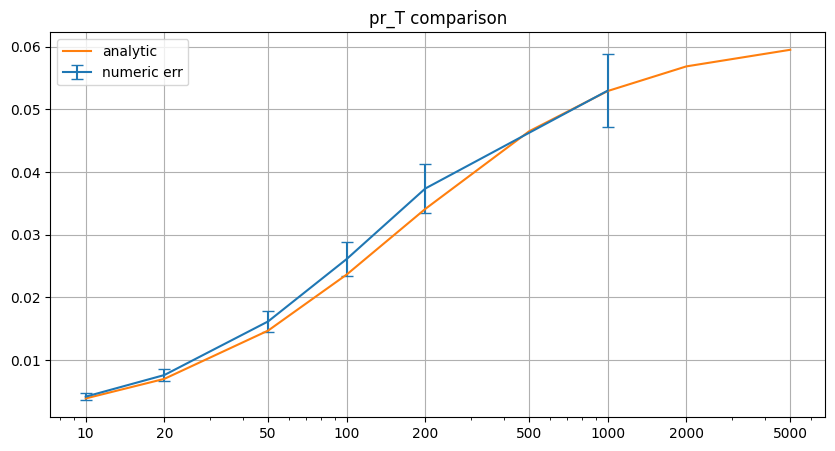

In [41]:
#compare
[plot_window_len_s, pr_s_free] = load_as_list("1000_free_pr.npz")
num_r_pr_s_mean_std = jnp.asarray([jnp.mean(pr_s_free, axis = (0,1,2,3,4,6)),
                                 jnp.std(pr_s_free, axis = (0,1,2,3,4,6))])
# num_r_pr_s_scatter = jnp.swapaxes(pr_s_free,5,0).flatten()
# plot_window_len_s_scatter = jnp.repeat(plot_window_len_s, pr_s_free[:,:,:,:,:,0].size)

plt.figure(figsize=(10,5))
plt.title("pr_T comparison")
plt.errorbar(plot_window_len_s, num_r_pr_s_mean_std[0], yerr=num_r_pr_s_mean_std[1], label = "numeric err", capsize = 4)
# plt.plot(plot_window_len_s_scatter, num_r_pr_s_scatter, label = "numeric sca", linestyle="", marker=".", markersize = 1)
plt.plot(window_len_s, r_pr_s, label = "analytic")
plt.xscale("log")
plt.xticks(window_len_s, labels = window_len_s)
plt.grid()
plt.legend()

trivial PR_T

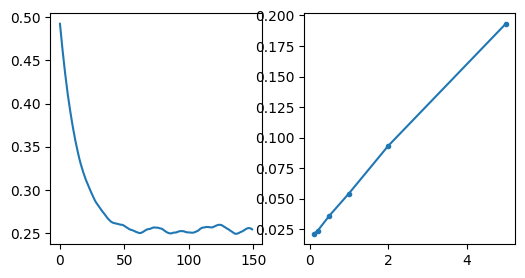

In [2]:
#trajectory
key = jrandom.PRNGKey(0)
part_n = 50
flip_n = 20
x_resolution = 30
flip_interval_s = jrandom.exponential(key, shape=(part_n, flip_n));
acov_traj_len = jnp.min(jnp.sum(jnp.round(flip_interval_s * x_resolution).astype(int), axis = -1))
traj = jnp.concatenate([jnp.concatenate([jnp.full((1, 
                                     jnp.round(flip_interval_s[part_idx, flip_idx]* x_resolution).astype(int)), flip_idx%2)
                           for flip_idx in range(flip_n)], axis = -1)[:, :acov_traj_len]
          for part_idx in range(part_n)])

#stats
[fig, subfig_s] = plt.subplots(1, 2, figsize = (6,3), squeeze = False)
subfig_s[0, 0].plot(jnp.mean(matched_correlation_fct(traj, traj, 0, 0), axis = 0)[:30*5])
window_len_s = jnp.asarray([0.1, 0.2,0.5,1,2,5])
samp_separation_with_n=samp_separation_with_n_fct(window_len_s, x_resolution)
kernel_s=kernel_s_fct(window_len_s, x_resolution, jnp.inf, 0.98)
multi_len_pr_tr_os_s=multi_len_pr_tr_os_s_fct(traj, x_resolution,
                             kernel_s, samp_separation_with_n)
subfig_s[0, 1].plot(window_len_s,
         jnp.mean(multi_len_pr_tr_os_s[0], axis = 1)[:-1], marker = '.')